In [297]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import imageio

from collections import deque

class TSP:

    def __init__(self, city_pos : list, city_dist : list):
        """
        tsp_n = number for tsp algorithm(DP), O(2^n * n^2)
        cluster_division_n = divide each cluster that has cities > this param
        path_tsp_n = number for path_tsp algorithms(Bruteforce), O(n!)
        kmeans_k = sklearn KMeans's cluster_n param
        kmeans_r = sklearn KMeans's random_state param
        """
        # private
        self.__city_pos = np.array(city_pos)
        self.__city_dist = np.array(city_dist)

        # public
        # stage 1: kmeans clustering
        self.kmeans_cluster_pos = None
        self.kmeans_cluster_cities = None
        self.kmeans_cluster_labels = None

        # stage 2: tsp path of kmeans clusters
        self.tsp_path = None
        
        # stage 3: new cluster_pos, cluster_cities sets, dividing each clusters that has too many cities
        # last element = best
        self.dividing_cluster_infos = []

        # stage 4: cluster path -> city path using path-tsp algorithm
        # last element = best
        self.path_tsp_process = []
        self.path_tsp_path = []
        self.path_tsp_dist = 0
        
        # last stage: untangling city path using path-tsp algorithm
        self.final_process = []
        self.final_path = None
        self.final_dist = 0


    def __get_pos_dist(self, a, b):
        return ((b[0] - a[0])**2 + (b[1] - a[1])**2)**0.5
    
    def __get_dist_table(self, pos):
        return np.array([[self.__get_pos_dist(pos[i], pos[j]) for j in range(pos.shape[0])] for i in range(pos.shape[0])])

    def __get_tsp(self, pos):
        def is_in(i, A):
            if ((A & (1 << (i-2))) != 0):
                return True
            else:
                return False

        def diff(A, j):
            t = 1 << (j - 2)
            return (A & (~t))

        def count(A, n):
            count = 0
            for i in range(n):
                if ((A & (1 << i)) != 0):
                    count += 1
            return count

        def travel(W):
            n = len(W) - 1
            size = 2 ** (n - 1)
            D = [[0] * size for _ in range(n + 1)]
            P = [[0] * size for _ in range(n + 1)]
            for i in range(2, n + 1):
                D[i][0] = W[i][1]
            for k in range(1, n - 1):
                for A in range(1, size):
                    if (count(A, n) == k):
                        for i in range(2, n + 1):
                            if (not is_in(i, A)):
                                D[i][A], P[i][A] = minimum(W, D, i, A)
            A = size - 1
            D[1][A], P[1][A] = minimum(W, D, 1, A)
            return D, P

        def minimum (W, D, i, A):
            minValue = 99999999
            minJ = 1
            n = len(W) - 1
            for j in range(2, n + 1):
                if (is_in(j, A)):
                    m = W[i][j] + D[j][diff(A, j)]
                    if (minValue > m):
                        minValue = m
                        minJ = j
            return minValue, minJ
        
        padding_pos = np.zeros((1,2))
        padding_pos = np.append(padding_pos, pos, axis=0)
        W = self.__get_dist_table(padding_pos)
        D, P = travel(W)
        
        tsp_path = [0]
        start, A = 1, len(P[1]) - 1
        while A != 0:
            start = P[start][A]
            tsp_path.append(start - 1)
            A = diff(A, start)

        return tsp_path

    def __get_center(self, *positions):
        points = []
        for i in range(len(positions[0])):
            points.append(sum([pos[i] for pos in positions]) / len(positions))
        return points

    def __make_func(self, point1, point2):
        m = (point2[1] - point1[1]) / (point2[0] - point1[0])
        return lambda x : m * (x - point1[0]) + point1[1]

    def __get_path_dist(self, path, pos_dist):
        ret = 0
        for i in range(len(path) - 1):
            ret += pos_dist[path[i]][path[i+1]]
        ret += pos_dist[path[-1]][path[0]]
        return ret
        
    def __find_end_city(self, path, c_idx, start, city_pos, cluster_pos, cluster_cities):
        return max([[c, self.__get_pos_dist(cluster_pos[c_idx], city_pos[c])] for c in cluster_cities[path[c_idx + 1]]], key=lambda x: x[1])[0]
    
    def __get_line_pos_dist(self, line_pos1, line_pos2, point_pos):
        area = abs((line_pos1[0]-point_pos[0]) * (line_pos2[1]-point_pos[1]) - (line_pos1[1]-point_pos[1]) * (line_pos2[0] - point_pos[0]))
        AB = ((line_pos1[0]-line_pos2[0])**2 + (line_pos1[1]-line_pos2[1])**2) **0.5
        distance = area/AB
        return distance

    def __get_cross_point(self, p1, p2, p3, p4):
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        x4, y4 = p4
        #print(p1, p2, p3, p4)
        if (x1-x2)*(y3- y4) - (y1-y2)*(x3-x4) == 0:
            print('?')
        X = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4))
        X /= ((x1-x2)*(y3- y4) - (y1-y2)*(x3-x4))
        Y = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4))
        Y /= ((x1-x2)*(y3- y4) - (y1-y2)*(x3-x4))
        #print(X, Y)
        return [X, Y]

    def __find_end_city2(self, path, c_idx, start, pos, c_pos, cluster_cities):
        
        cities = cluster_cities[path[c_idx+1]]
        
        dot_a = pos[start]
        dot_b = c_pos[path[c_idx]]
        
        #선분간의 거리, 자기 중점과의 거리의 차가 가장 작은놈 고른다

        dot_c = c_pos[path[(c_idx+1) % len(path)]]
        dot_d = c_pos[path[(c_idx+2) % len(path)]]

        close_rank = sorted(cities, key=lambda c: self.__get_line_pos_dist(dot_a, dot_b, pos[c]))
        far_rank = sorted(cities, key=lambda c: self.__get_line_pos_dist(dot_c, dot_d, pos[c]), reverse=True)
        
        score_table = {c: 0 for c in cities}
        
        for i in range(len(cities)):
            score_table[close_rank[i]] += len(cities) - i
            score_table[far_rank[i]] += len(cities) - i
            
        max_score = max(score_table.values())
        max_cities = [c for c, v in score_table.items() if v == max_score]
        
        # 이 시티들 중 가장 교점과 가까운 놈
        cross_point = self.__get_cross_point(dot_a, dot_b, dot_c, dot_d)
        #print(far_rank, close_rank)
        # 거리로 솔트
        max_cities.sort(key=lambda city: self.__get_pos_dist(pos[city], cross_point))
        
    #     # 다음 군집에서 가장 가까운 도시
    #     ct = cluster_cities[path[(c_idx+1)%len(path)]][0]
    #     min_d = get_dist(pos[ct], pos[max_cities[0]])
    #     for c in cluster_cities[path[(c_idx+1)%len(path)]][1:]:
    #         dist = get_dist(pos[c], pos[max_cities[0]])
    #         if min_d > dist:
    #             ct = c
    #             min_d = dist
        return max_cities[0]
        
    def __DFS_path_tsp(self, start, end, cities, pos_dist):
        # 우선 스타트시티가 들어있는 군집의 모든 도시들 나열 스타트시티 제외하고
        cities = [c for c in cities if c != start]
        
        global glob_path
        global glob_dist
            
        glob_path = [start] + cities + [end]
        glob_dist = self.__get_path_dist(glob_path, pos_dist)
        
        def dfs(npath, extra, pos_dist, accum_dist):
            global glob_path
            global glob_dist
            
            # promising
            if accum_dist > glob_dist:
                return
            if len(npath) == len(cities) + 1:
                new_dist = self.__get_path_dist(npath + [end], pos_dist)
                if glob_dist > new_dist:
                    glob_path = npath + [end]
                    glob_dist = new_dist
                    # print(glob_dist)
            else:
                for e in extra:
                    npath.append(e)

                    new_extra = [e for e in extra if e != npath[-1]]
                    dfs(npath, new_extra, pos_dist, accum_dist + pos_dist[npath[-2]][npath[-1]])

                    npath.pop()

        dfs([start], cities, pos_dist, 0)

        return glob_path[:-1]

    def set_params(self, tsp_n = 20, cluster_division_n = 8 ,path_tsp_n = 10, kmeans_k = -1, kmeans_rseed = 0):
        self.__tsp_n = tsp_n
        self.__cluster_division_n = cluster_division_n
        self.__path_tsp_n = path_tsp_n
        self.__kmeans_k = kmeans_k
        self.__kmeans_rseed = kmeans_rseed

    def run(self, pause_s = 0, tsp_n = 20, division_bound = 8, division_untangle_n = 10, untangling_path_tsp_n = 9,kmeans_k = -1, kmeans_rseed = 0):
        # just do only tsp algorithm
        if self.__city_pos.shape[0] < 20:
            return self.__get_tsp(self.__city_pos)


        # stage 1: kmeans clustering
        print('s1 kmeans clustering', flush=True)
        if kmeans_k == -1:
            K = min((self.__city_pos.shape[0] // division_bound) + 1, tsp_n)
        else:
            K = kmeans_k
        
        model = KMeans(K, random_state=kmeans_rseed)
        model.fit(self.__city_pos)
        
        self.kmeans_cluster_pos = model.cluster_centers_
        self.kmeans_cluster_labels = model.labels_
        self.kmeans_cluster_cities = [[c for c, label in enumerate(model.labels_) if label == C] for C in range(model.cluster_centers_.shape[0])]
        print(' done     ')

        # stage 2: do tsp with clusters
        print('s2 tsp finding', flush=True)
        self.tsp_path = self.__get_tsp(self.kmeans_cluster_pos)
        print(' done     ')

        # stage 3: dividing clusters that has too many cities (until <= cluster_division_n)
        print('s3 cluster dividing', flush=True)
        d_cluster_pos = self.kmeans_cluster_pos.copy()
        d_cluster_labels = self.kmeans_cluster_labels[:]
        d_cluster_cities = self.kmeans_cluster_cities[:]
        d_path = self.tsp_path[:]
        
        most_cluster_cities = max(self.kmeans_cluster_cities, key=lambda x: len(x))

        remaining = sum([max(len(cities) - division_bound, 0) for cities in d_cluster_cities])

        divisior = len(most_cluster_cities) - division_bound
        while len(most_cluster_cities) > division_bound:
            print(f' {((remaining - sum([max(len(cities) - division_bound, 0) for cities in d_cluster_cities])) * 100) / remaining:.2f}%\r', end='')
            C_divide = d_cluster_cities.index(most_cluster_cities)
            d_path_idx = d_path.index(C_divide)

            # 얘네를 가까운 도시 위치로 하는것도
            b_center, f_center = d_cluster_pos[d_path[d_path_idx-1]], d_cluster_pos[d_path[(d_path_idx+1)%len(d_path)]]
            
            b_cities, f_cities = [], []

            center = self.__get_center(b_center, f_center)
            f = self.__make_func(center, d_cluster_pos[C_divide])

            for c in d_cluster_cities[C_divide]:
                # m = (dividing_cluster_pos[C_divide][1] - center[1]) / (dividing_cluster_pos[C_divide][0] - center[0])
                if f(self.__city_pos[c][0]) >= self.__city_pos[c][1]:
                    b_cities.append(c)
                else:
                    f_cities.append(c)

            # print(b_cities, f_cities)
            b_cluster_centroid = self.__get_center(*[self.__city_pos[c] for c in b_cities])
            f_cluster_centroid = self.__get_center(*[self.__city_pos[c] for c in f_cities])
            
            # 새로 센트로이드까지 구했으니, 서로 센트로이드 기준으로 먼거 맞교환
            
            f_to_b = []
            for fc in f_cities:
                if self.__get_pos_dist(self.__city_pos[fc], f_cluster_centroid) > self.__get_pos_dist(self.__city_pos[fc], b_cluster_centroid):
                    f_to_b.append(fc)
            
            for c in f_to_b:
                f_cities.remove(c)
                b_cities.append(c)
            
            b_to_f = []
            for bc in b_cities:
                if self.__get_pos_dist(self.__city_pos[bc], b_cluster_centroid) > self.__get_pos_dist(self.__city_pos[bc], f_cluster_centroid):
                    b_to_f.append(bc)
                    
            for c in b_to_f:
                b_cities.remove(c)
                f_cities.append(c)
            
            b_cluster_centroid = self.__get_center(*[self.__city_pos[c] for c in b_cities])
            f_cluster_centroid = self.__get_center(*[self.__city_pos[c] for c in f_cities])
        

            bf_pos = [d_cluster_pos[d_path[d_path_idx-1]], b_cluster_centroid, 
                f_cluster_centroid, d_cluster_pos[d_path[(d_path_idx+1)%len(d_path)]]]
            bf_dist = self.__get_pos_dist(bf_pos[0], bf_pos[1]) + self.__get_pos_dist(bf_pos[1], bf_pos[2]) + self.__get_pos_dist(bf_pos[2], bf_pos[3])
            
            fb_pos = [d_cluster_pos[d_path[d_path_idx-1]], f_cluster_centroid, 
                b_cluster_centroid, d_cluster_pos[d_path[(d_path_idx+1)%len(d_path)]]]
            fb_dist = self.__get_pos_dist(fb_pos[0], fb_pos[1]) + self.__get_pos_dist(fb_pos[1], fb_pos[2]) + self.__get_pos_dist(fb_pos[2], fb_pos[3])
            
            if bf_dist < fb_dist:
                d_cluster_cities[C_divide] = f_cities
                d_cluster_cities.append(b_cities)

                d_cluster_pos[C_divide] = f_cluster_centroid
                d_cluster_pos = np.append(d_cluster_pos, np.array([b_cluster_centroid]), axis=0)
                for i in range(len(d_cluster_labels)):
                    if i in b_cities:
                        d_cluster_labels[i] = len(d_path) - 1
            else:
                d_cluster_cities[C_divide] = b_cities
                d_cluster_cities.append(f_cities)

                d_cluster_pos[C_divide] = b_cluster_centroid
                d_cluster_pos = np.append(d_cluster_pos, np.array([f_cluster_centroid]), axis=0)

                for i in range(len(d_cluster_labels)):
                    if i in f_cities:
                        d_cluster_labels[i] = len(d_path) - 1
            
            d_path.insert(d_path_idx, len(d_path))
            
            sub_cluster_dist = self.__get_dist_table(d_cluster_pos)
 
            d_path_q = deque(d_path)
            d_path_q.rotate(len(d_path) - 2 - d_path_idx)
            d_path = list(d_path_q)
            
            d_path_idx = len(d_path) - 2
            s, e = d_path_idx - min(len(d_path) - 2, division_untangle_n - 2), (d_path_idx + 1)
            
            sub_path = d_path[s:e + 1]
            new_path = self.__DFS_path_tsp(d_path[s], d_path[e], sub_path[:-1], sub_cluster_dist) + [d_path[e]]

            for i in range(s, e + 1):
                d_path[i] = new_path[i - s] 
                
            d_path_q.rotate(-(len(d_path) - 2))
            d_path = list(d_path_q)
            d_path_idx = 1
            
            s, e = d_path_idx - 1, d_path_idx + min(len(d_path) - 2, division_untangle_n - 2)
            sub_path = d_path[s:e + 1]
            new_path = self.__DFS_path_tsp(d_path[s], d_path[e], sub_path[:-1], sub_cluster_dist) + [d_path[e]]

            for i in range(s, e + 1):
                d_path[i] = new_path[i - s] 

            self.dividing_cluster_infos.append([d_cluster_pos.copy(), d_cluster_cities[:], d_cluster_labels[:], d_path[:]])
            most_cluster_cities = max(d_cluster_cities, key=lambda x: len(x))
        
        print(' done     ')

        # stage 4: path-tsp
        print('s4 path-tsp finding', flush=True)
        cluster_pos = self.dividing_cluster_infos[-1][0]
        cluster_cities = self.dividing_cluster_infos[-1][1]
        cluster_labels = self.dividing_cluster_infos[-1][2]
        path = self.dividing_cluster_infos[-1][3]

        start = max([[c, self.__get_pos_dist(self.__city_pos[c], cluster_pos[path[1]])] for c in cluster_cities[path[0]]], key=lambda x: x[1])[0]

        first = start
        for i in range(len(path) - 1):            
            print(f' {(i / len(path)) * 100:.2f}%\r', end='')
            end = self.__find_end_city2(path, i, start, self.__city_pos, cluster_pos, cluster_cities)
            sub_path_tsp_path = self.__DFS_path_tsp(start, end, cluster_cities[path[i]], self.__city_dist)
            self.path_tsp_path += sub_path_tsp_path
            self.path_tsp_process.append(self.path_tsp_path[:])
            start = end
        self.path_tsp_path += self.__DFS_path_tsp(start, first, cluster_cities[path[-1]], self.__city_dist)
        self.path_tsp_dist = self.__get_path_dist(self.path_tsp_path + [self.path_tsp_path[-1]], self.__city_dist)

        print(' done     ')

        # last stage: untangling
        print('s5 path untangling', flush=True)

        self.final_path = self.path_tsp_path[:]
        s, e = 0, untangling_path_tsp_n - 1
        gap = 0
        while e < len(self.final_path):
            print(f' {(e / len(self.final_path)) * 100:.2f}%\r', end='')
            sub_path = self.final_path[s:e + 1]
            new_path = self.__DFS_path_tsp(self.final_path[s], self.final_path[e], sub_path[:-1], self.__city_dist) + [self.final_path[e]]
            # sd = self.__get_path_dist(sub_path, self.__city_dist)
            # nd = self.__get_path_dist(new_path, self.__city_dist)
            # gap += sd - nd
            # # print(sub_path, new_path, f'{sd:7.2f}, {nd:7.2f}', f'|| gap: {gap:.2f}', e)
            for i in range(s, e + 1):
                self.final_path[i] = new_path[i - s] 

            if self.final_path not in [e[0] for e in self.final_process]:
                self.final_process.append([self.final_path[:], self.__get_path_dist(self.final_path + [self.final_path[0]], self.__city_dist)])
            s += 1
            e += 1
        
        self.final_dist = self.__get_path_dist(self.final_path + [self.final_path[0]], self.__city_dist)
        print(' done      ')
        

def draw_path(path : list, pos : np.ndarray, dist : int = None, city_pos: list = [], mod = None, save = None, figsize : tuple = None):

    if figsize != None:
        plt.figure(figsize=figsize)
    
    if len(city_pos):
        plt.scatter([pos[0] for pos in city_pos], [pos[1] for pos in city_pos], s=10, alpha=0.3, c='black')
  
    if dist != None:
        plt.text(0, 0, f'Len: {dist:.2f}')

    if mod != None:
        plt.plot([pos[c][0] for c in path[mod[1] + 1:]], [pos[c][1] for c in path[mod[1] + 1:]], c='r')
        plt.plot([city_pos[c][0] for c in mod[0]], [city_pos[c][1] for c in mod[0]], c='r')
    else:
        plt.plot([pos[c][0] for c in path + [path[0]]], [pos[c][1] for c in path + [path[0]]], c='r')

    if save != None:
        plt.savefig(os.path.join(f'{save[0]}', f'{save[0]}_{save[1]:05}.png'))
        plt.close()

def make_gif(tsp_obj : TSP, file_name : str, coords : list = [], figsize : tuple = None):
    image_num = 0
    try:
        os.mkdir(file_name)
    except:
        pass

    draw_path(path=tsp_obj.tsp_path, pos=tsp_obj.kmeans_cluster_pos, city_pos=coords, save=[file_name, image_num], figsize=figsize)
    image_num += 1

    for i in range(len(tsp_obj.dividing_cluster_infos)):
        draw_path(path=tsp_obj.dividing_cluster_infos[i][-1], pos=tsp_obj.dividing_cluster_infos[i][0], city_pos=coords, save=[file_name, image_num], figsize=figsize)
        image_num += 1

    for i in range(len(tsp_obj.path_tsp_process)):
        draw_path(path=tsp_obj.dividing_cluster_infos[-1][-1], pos=tsp_obj.dividing_cluster_infos[-1][0], city_pos=coords, save=[file_name, image_num], 
        mod=[tsp_obj.path_tsp_process[i], i + 1], figsize=figsize)
        image_num += 1

    for i in range(len(tsp_obj.final_process)):
        draw_path(path=[int(c) for c in tsp_obj.final_process[i][0]], pos=coords, city_pos=coords, dist = tsp_obj.final_process[i][1], save=[file_name, image_num], figsize=figsize)
        image_num += 1

    for i in range(30):
        draw_path(path=tsp_obj.final_process[-1][0], pos=coords, city_pos=coords, dist = tsp_obj.final_process[-1][1], save=[file_name, image_num], figsize=figsize)
        image_num += 1

    imgs = []
    for file_n in os.listdir(file_name):
        if file_n.endswith(f'.png'):
            file_path = os.path.join(file_name, file_n)
            imgs.append(imageio.imread_v2(file_path))
    imageio.mimsave(f'{file_name}.gif', imgs, **{'duration':0.1})


In [298]:
# prepare x, y pos list n by 2
coords = []
with open('att48.txt') as f:
    for line in f.readlines():
        coords.append(list(map(float, line.split()[1:])))

# prepare Euclidian distance table
coord_dist = [[((coords[i][0] - coords[j][0]) ** 2 + (coords[i][1] - coords[j][1]) ** 2) ** 0.5 for j in range(len(coords))] for i in range(len(coords))]

In [299]:
tsp_obj = TSP(coords, coord_dist)
tsp_obj.run(tsp_n=16, division_bound=6, division_untangle_n=11, untangling_path_tsp_n=12)

s1 kmeans clustering
 done     
s2 tsp finding
 done     
s3 cluster dividing
 done     
s4 path-tsp finding
 done     
s5 path untangling
 done      


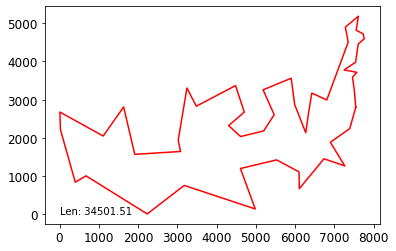

In [296]:
draw_path(tsp_obj.final_path, coords, tsp_obj.final_dist)

In [295]:
make_gif(tsp_obj, 'att48', coords = coords)